In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import gym
from gym import spaces

import numpy as np
import pandas as pd
import joblib

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.rcParams['figure.figsize'] = [14, 7]

In [2]:
#загрузка графика
loaded_track = pd.read_csv('data.csv', index_col=0).to_numpy(dtype='int64').flatten()
loaded_track

array([  -8,   -4,   -2, ..., 9084, 9074, 9074])

Инициализация среды

In [3]:
#класс среды
class MarketEnv(gym.Env):
    """
    Custom Environment that follows gym interface.
    This is a an env where the agent must learn to trade. 
    """
    metadata = {'render.modes': ['human']}
    
    NEUTRAL = 0
    SHORT = 1
    LONG = 2
    
    def __init__(self, track):
        super(MarketEnv, self).__init__()
        
        self.track = track #полный график
        self.start = 0
        self.current = 200 - 1
        self.end = 200 #для среза
        self.agent_situation = self.track[self.start:self.end] 
       
        self.action = 0
        n_actions = 3
        self.action_space = spaces.Discrete(n_actions)
        self.observation_space = spaces.MultiDiscrete([4e8] * 200)
        
    def reset(self):
        """
        Important: the observation must be a numpy array
        :return: (np.array) 
        """
        # Initialize the agent at the point on the track where
        #he observes first 200 datapoints
        
        self.start = 0
        self.current = 200 - 1
        self.end = 200
        self.agent_situation = self.track[self.start:self.end]
        self.action = 0
        return self.agent_situation
    
    def step(self, action):
        if action == self.NEUTRAL:
            self.action = 0
        elif action == self.SHORT:
            self.action = -1
        elif action == self.LONG:
            self.action = 1 
        else:
            raise ValueError("Received invalid action={} which is \
                             not part of the action space".format(action))
        
        # Are we at the end of the track?
        done = bool(self.end == 1e6)
        
        price_move = self.track[self.end] - self.agent_situation[-1]
        reward = float(price_move * self.action) 
        
        # Optionally we can pass additional info, we are not using that for now
        info = {}
        
        #new state
        self.start +=1
        self.current +=1
        self.end +=1
    
        self.agent_situation = self.track[self.start:self.end]

        return self.agent_situation, reward, done, info
    
    def render(self, mode='human'):
        if mode != 'human':
            raise NotImplementedError()
        
        plt.plot(self.agent_situation)
        
        if self.action == 0:
            plt.title('NEUTRAL', color='w');
        elif self.action == -1:
            plt.title('SHORT', color='r');
        elif self.action == 1:
            plt.title('LONG', color='g');
    
    def close(self):
        pass

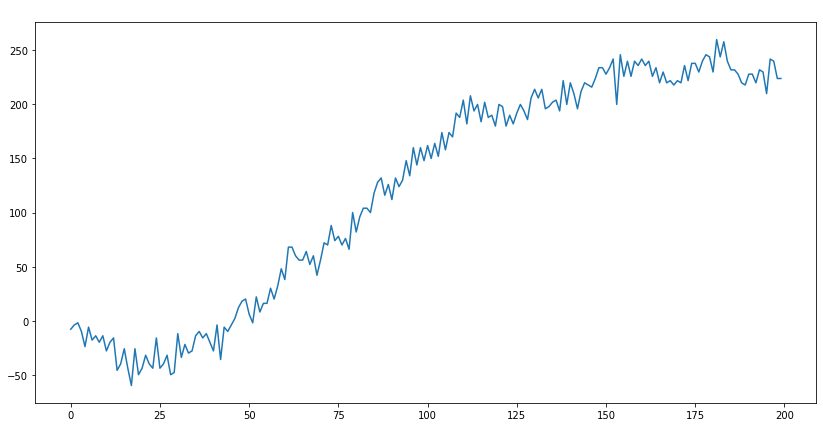

In [4]:
#инициализируем среду
env = MarketEnv(loaded_track)
env.reset()
env.render()

Простейший агент

In [5]:
#простейший агент
agent = MLPClassifier(
    hidden_layer_sizes=(80, 30, 10),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
n_actions = env.action_space.n
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(80, 30, 10))

Самописный агент

In [8]:
#модель - полносвязная сеть
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.Linear(20, 3),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
#инициализация модели
agent = FCN()
print(agent)

FCN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=3, bias=True)
  )
)


In [10]:
#детальные параметры сети
for name, parameter in agent.named_parameters():
    print(name, parameter)

linear_relu_stack.0.weight Parameter containing:
tensor([[-0.0658,  0.0051, -0.0022,  ..., -0.0587, -0.0642,  0.0621],
        [ 0.0107, -0.0620, -0.0033,  ..., -0.0624, -0.0258, -0.0402],
        [-0.0272,  0.0542,  0.0257,  ..., -0.0349, -0.0657,  0.0319],
        ...,
        [-0.0179,  0.0096,  0.0134,  ...,  0.0458,  0.0286,  0.0426],
        [-0.0464,  0.0144, -0.0113,  ...,  0.0238,  0.0366,  0.0394],
        [-0.0169, -0.0595, -0.0117,  ...,  0.0216,  0.0619,  0.0504]],
       requires_grad=True)
linear_relu_stack.0.bias Parameter containing:
tensor([ 0.0300,  0.0515, -0.0508,  0.0507, -0.0104, -0.0311, -0.0385,  0.0126,
         0.0011,  0.0200,  0.0093,  0.0453, -0.0429, -0.0051,  0.0477,  0.0505,
        -0.0321, -0.0151, -0.0565, -0.0245,  0.0460,  0.0025, -0.0340,  0.0395,
        -0.0115,  0.0401, -0.0331, -0.0492, -0.0679,  0.0352, -0.0051, -0.0118,
         0.0520, -0.0218, -0.0002,  0.0685,  0.0179, -0.0528, -0.0458,  0.0428,
        -0.0390,  0.0579,  0.0343,  0.0546,

... После этого момента для отладки можно сделать прогон для получения первых elite sessions
(если инициализированы соответствующие функции)

In [24]:
%%time
#вручную генерируем первые элитные сессии

n_sessions = 5
sessions = [generate_session(env, agent, t_max=99000) for i in range(n_sessions)]

states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

percentile = 80
elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

CPU times: user 1min 3s, sys: 2.04 s, total: 1min 5s
Wall time: 1min 7s


In [25]:
#необходимый класс для датасета
class States_Actions_Dataset(Dataset):
    def __init__(self, states, actions, transform=None):
        super().__init__()
        self.states = states
        self.actions = actions
        self.transform = transform

    def __len__(self):
        return len(self.actions)

    def __getitem__(self, idx):
        state = self.transform(self.states[idx])
        action = self.transform(self.actions[idx])
        return {'state':state, 'action':action}

In [26]:
def transform(x):
    '''Transforming input data'''
    if type(x) == np.ndarray:
        x = torch.FloatTensor(x.astype(np.int64)) 
        last_value = x.clone()[-1]
        x -= last_value
        standard_dev = torch.var(x, unbiased=False)
        x /= standard_dev
    
    elif type(x) == int: #для y
        x = torch.tensor(x).long()
    
    return x

In [27]:
def create_dataloaders(elite_states, elite_actions):
    '''Создаем даталоадеры "на лету"'''
    
    states_train, actions_train = elite_states, elite_actions

    train_dataset = States_Actions_Dataset(states_train, actions_train, 
                                          transform=lambda x: transform(x))
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
   
    return train_dataloader

In [36]:
#параметры
learning_rate = 1e-1
batch_size = 64
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [29]:
def train_iteration(dataloader, agent, loss_fn, optimizer):
    '''Одна итерация (один проход) обучения'''
    size = dataloader.__len__()
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    
    for batch, data in enumerate(dataloader): 
        X = data['state']
        y = data['action']
        
        # Compute prediction and loss
        pred = agent(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Накопление значений для метрик
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    # Подсчет метрик усреднением
    train_loss /= num_batches
    train_correct /= size
    
    return train_loss, train_correct

In [30]:
def train_loop(dataloader, epochs):
    '''Объединение нескольких итераций в цикл из нескольких эпох и вывод результатов
    Обращается к глобальным переменным
    Dataloader надо передавать, так как создается в процессе'''
    train_accuracy_progression = []
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss, train_accuracy = train_iteration(dataloader, agent, loss_fn, optimizer)
        train_accuracy_progression.append(train_accuracy)
        print("Train accuracy: ", train_accuracy)
    
    print("Train accuracy progression: ", train_accuracy_progression)

In [31]:
def fit(elite_states, elite_actions, epochs):
    '''Мастер-функция, обращается к глобальным переменным'''
    agent.train()
    dataloader = create_dataloaders(elite_states, elite_actions)
    train_loop(dataloader, epochs)    

In [32]:
#сохраняем / загружаем elite_states и elite_actions,
#чтобы попробовать обучить на них отдельно
pd.DataFrame(elite_states).to_csv('elite_states.csv')
pd.DataFrame(elite_actions).to_csv('elite_actions.csv')

In [33]:
#проверочная загрузка
loaded_elite_states = pd.read_csv('elite_states.csv', index_col=0).to_numpy(dtype='int64')
loaded_elite_actions = pd.read_csv('elite_actions.csv', index_col=0).to_numpy(dtype='int64').flatten()

In [34]:
len(loaded_elite_states), len(loaded_elite_actions)

(99000, 99000)

Пытаемся обучить на пробных элитных сессиях

In [38]:
fit(elite_states, elite_actions, epochs)

Epoch 1
-------------------------------
Train accuracy:  11.723658694246929
Epoch 2
-------------------------------
Train accuracy:  11.680349062702003
Epoch 3
-------------------------------
Train accuracy:  11.638332255979314
Epoch 4
-------------------------------
Train accuracy:  11.667744020685197
Epoch 5
-------------------------------
Train accuracy:  11.721719457013574
Train accuracy progression:  [11.723658694246929, 11.680349062702003, 11.638332255979314, 11.667744020685197, 11.721719457013574]


In [24]:
#проверка параметров сети
next(agent.parameters())

Parameter containing:
tensor([[ 6.0348e+00,  6.0243e+00,  5.9816e+00,  ..., -5.8556e+00,
         -5.9160e+00,  4.4232e-02],
        [ 1.5642e+01,  1.0251e+01,  1.8315e+01,  ...,  5.2390e-01,
          1.8684e+01,  8.7010e-03],
        [ 7.4245e+00,  7.0901e+00,  8.1643e+00,  ..., -6.0018e+00,
         -6.1239e+00,  4.7084e-02],
        ...,
        [-7.5764e+00, -7.6064e+00, -7.7969e+00,  ..., -4.7991e+00,
         -7.4421e+00, -2.4833e-02],
        [ 2.9088e+01,  2.2366e+01,  2.5916e+01,  ..., -2.4271e-01,
          2.3957e+01,  2.5531e-02],
        [-3.9524e+00, -1.4830e+01, -8.8454e+00,  ...,  5.6082e+00,
          1.1718e+01, -8.0568e-03]], requires_grad=True)

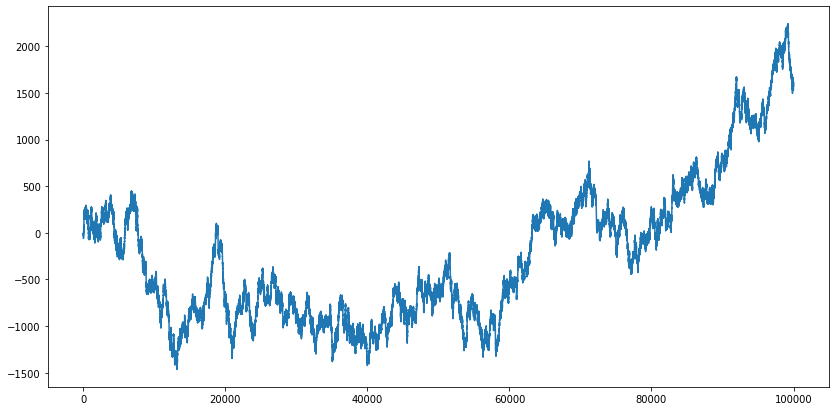

In [39]:
plt.plot(loaded_track[:100000])

In [42]:
#проверка того, что находится в даталоадере
for i in iter(create_dataloaders(elite_states, elite_actions)):
    print(i)

{'state': tensor([[-0.0247, -0.0273, -0.0273,  ..., -0.0017, -0.0017,  0.0000],
        [-0.0031,  0.0102,  0.0020,  ...,  0.0072,  0.0031,  0.0000],
        [-0.0029,  0.0200,  0.0029,  ...,  0.0000, -0.0057,  0.0000],
        ...,
        [ 0.0710,  0.0533,  0.0604,  ..., -0.0284, -0.0107,  0.0000],
        [ 0.0595,  0.0657,  0.0606,  ..., -0.0017,  0.0028,  0.0000],
        [ 0.0111, -0.0166,  0.0083,  ...,  0.0028,  0.0221,  0.0000]]), 'action': tensor([1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 2, 2, 0, 2, 2, 1, 2,
        2, 0, 2, 2, 0, 2, 1, 0])}
{'state': tensor([[-0.0389, -0.0363, -0.0385,  ...,  0.0004,  0.0038,  0.0000],
        [-0.0309, -0.0422, -0.0391,  ..., -0.0062,  0.0010,  0.0000],
        [-0.0146,  0.0016, -0.0244,  ..., -0.0146, -0.0195,  0.0000],
        ...,
        [-0.0199, -0.0178, -0.0136,  ...,  0.0000,  0.0073,  0.0000],
        [ 0.0632,  0.0683,  0.0632,  ...,  0.0084,  0.0025,  0.0000],
        [ 0.1759,  0.1649,  0.1594,  ...,  0.0000,  0.0165

{'state': tensor([[-0.0957, -0.0775, -0.0501,  ...,  0.0000,  0.0137,  0.0000],
        [-0.0536, -0.0498, -0.0487,  ..., -0.0022,  0.0011,  0.0000],
        [ 0.0456,  0.0463,  0.0456,  ...,  0.0046,  0.0046,  0.0000],
        ...,
        [-0.0289, -0.0346, -0.0217,  ...,  0.0043, -0.0144,  0.0000],
        [ 0.0160,  0.0195,  0.0240,  ..., -0.0115, -0.0034,  0.0000],
        [ 0.0260,  0.0364,  0.0130,  ...,  0.0260, -0.0052,  0.0000]]), 'action': tensor([1, 0, 2, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2,
        2, 1, 2, 1, 2, 2, 1, 2])}
{'state': tensor([[ 0.0208,  0.0238,  0.0232,  ...,  0.0000, -0.0030,  0.0000],
        [ 0.0017,  0.0009,  0.0035,  ..., -0.0052, -0.0009,  0.0000],
        [ 0.0376,  0.0362,  0.0313,  ...,  0.0027,  0.0009,  0.0000],
        ...,
        [-0.0534, -0.0721, -0.0454,  ...,  0.0240,  0.0053,  0.0000],
        [-0.1316, -0.1157, -0.1452,  ..., -0.0318,  0.0113,  0.0000],
        [-0.0698, -0.0746, -0.0710,  ..., -0.0073, -0.0061

{'state': tensor([[ 0.1229,  0.1118,  0.0931,  ...,  0.0186,  0.0410,  0.0000],
        [ 0.0132,  0.0110,  0.0066,  ..., -0.0044, -0.0220,  0.0000],
        [-0.0348, -0.0312, -0.0385,  ...,  0.0119,  0.0064,  0.0000],
        ...,
        [-0.0033, -0.0119, -0.0054,  ...,  0.0038, -0.0005,  0.0000],
        [ 0.0296,  0.0280,  0.0214,  ...,  0.0099,  0.0049,  0.0000],
        [-0.0319, -0.0191, -0.0127,  ...,  0.0064, -0.0191,  0.0000]]), 'action': tensor([0, 0, 2, 1, 0, 0, 1, 2, 2, 0, 2, 2, 1, 1, 0, 1, 0, 2, 2, 1, 0, 0, 2, 2,
        1, 0, 0, 0, 0, 0, 1, 0])}
{'state': tensor([[ 0.0301,  0.0376,  0.0627,  ...,  0.0000,  0.0427,  0.0000],
        [-0.0008, -0.0047,  0.0062,  ...,  0.0031,  0.0031,  0.0000],
        [ 0.0050,  0.0150, -0.0100,  ..., -0.0050,  0.0075,  0.0000],
        ...,
        [ 0.0205,  0.0238,  0.0230,  ..., -0.0066, -0.0057,  0.0000],
        [ 0.1377,  0.1874,  0.1492,  ..., -0.0421,  0.0000,  0.0000],
        [ 0.0241,  0.0235,  0.0231,  ...,  0.0003, -0.0020

{'state': tensor([[-0.0212, -0.0255, -0.0276,  ...,  0.0000, -0.0021,  0.0000],
        [ 0.0133,  0.0167,  0.0122,  ..., -0.0100, -0.0011,  0.0000],
        [ 0.0263,  0.0176,  0.0146,  ...,  0.0015,  0.0088,  0.0000],
        ...,
        [ 0.0539,  0.0484,  0.0297,  ..., -0.0176, -0.0099,  0.0000],
        [-0.0489, -0.0463, -0.0468,  ..., -0.0031, -0.0005,  0.0000],
        [-0.0350, -0.0608, -0.0561,  ...,  0.0093,  0.0047,  0.0000]]), 'action': tensor([2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 2, 2, 0, 2, 0, 2, 0, 2, 2,
        2, 0, 0, 1, 0, 2, 2, 2])}
{'state': tensor([[-0.0773, -0.1044, -0.0793,  ...,  0.0084,  0.0125,  0.0000],
        [ 0.0278,  0.0293,  0.0285,  ..., -0.0068, -0.0038,  0.0000],
        [-0.0474, -0.0446, -0.0474,  ...,  0.0111,  0.0446,  0.0000],
        ...,
        [ 0.0355,  0.0382,  0.0412,  ..., -0.0031, -0.0046,  0.0000],
        [-0.0728, -0.0622, -0.0683,  ..., -0.0046, -0.0015,  0.0000],
        [-0.0984, -0.0797, -0.0937,  ..., -0.0281,  0.0000

{'state': tensor([[ 0.0153,  0.0110,  0.0170,  ..., -0.0034, -0.0051,  0.0000],
        [ 0.0331,  0.0530,  0.0641,  ...,  0.0000, -0.0155,  0.0000],
        [-0.0504, -0.0504, -0.0508,  ...,  0.0000,  0.0026,  0.0000],
        ...,
        [ 0.0333,  0.0322,  0.0333,  ...,  0.0000, -0.0018,  0.0000],
        [ 0.0383,  0.0514,  0.0364,  ..., -0.0056,  0.0028,  0.0000],
        [ 0.1137,  0.1042,  0.0961,  ...,  0.0108,  0.0203,  0.0000]]), 'action': tensor([2, 0, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 1, 0, 0, 2, 1, 1, 1, 2, 1, 2, 2, 1,
        2, 1, 0, 2, 2, 0, 0, 0])}
{'state': tensor([[ 0.1205,  0.1327,  0.1266,  ...,  0.0183, -0.0046,  0.0000],
        [ 0.0667,  0.0849,  0.0819,  ..., -0.0061,  0.0000,  0.0000],
        [ 0.0907,  0.0886,  0.0799,  ...,  0.0130,  0.0151,  0.0000],
        ...,
        [-0.0873, -0.0857, -0.1038,  ..., -0.0115, -0.0082,  0.0000],
        [-0.0624, -0.0525, -0.0556,  ..., -0.0053,  0.0008,  0.0000],
        [-0.0344, -0.0422, -0.0469,  ..., -0.0062,  0.0094

{'state': tensor([[ 0.0850,  0.0863,  0.0950,  ..., -0.0013, -0.0038,  0.0000],
        [ 0.0749,  0.0621,  0.0657,  ...,  0.0110,  0.0128,  0.0000],
        [-0.0360, -0.0265, -0.0233,  ..., -0.0064, -0.0106,  0.0000],
        ...,
        [-0.0509, -0.0553, -0.0574,  ...,  0.0065, -0.0022,  0.0000],
        [-0.0488, -0.0453, -0.0436,  ...,  0.0061,  0.0105,  0.0000],
        [-0.0391, -0.0357, -0.0372,  ...,  0.0019, -0.0005,  0.0000]]), 'action': tensor([2, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 0, 2, 2, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0])}
{'state': tensor([[-0.0623, -0.0541, -0.0731,  ...,  0.0271,  0.0244,  0.0000],
        [-0.1014, -0.0946, -0.1060,  ..., -0.0091, -0.0023,  0.0000],
        [ 0.0529,  0.0471,  0.0508,  ...,  0.0021,  0.0026,  0.0000],
        ...,
        [-0.0259, -0.0234, -0.0242,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0870,  0.0811,  0.0743,  ...,  0.0000,  0.0029,  0.0000],
        [ 0.0405,  0.0202,  0.0455,  ...,  0.0557,  0.0101

{'state': tensor([[ 0.0033,  0.0149, -0.0083,  ..., -0.0231, -0.0099,  0.0000],
        [-0.0582, -0.0523, -0.0550,  ...,  0.0027, -0.0033,  0.0000],
        [-0.0319, -0.0404, -0.0447,  ..., -0.0011, -0.0011,  0.0000],
        ...,
        [ 0.0818,  0.1432,  0.1514,  ...,  0.0286,  0.1023,  0.0000],
        [ 0.0070,  0.0043,  0.0104,  ...,  0.0052,  0.0061,  0.0000],
        [ 0.0076, -0.0267, -0.0114,  ..., -0.0114, -0.0305,  0.0000]]), 'action': tensor([0, 0, 0, 0, 2, 1, 2, 2, 1, 2, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 2, 1, 1,
        0, 2, 1, 0, 2, 1, 0, 1])}
{'state': tensor([[ 0.0293,  0.0119,  0.0195,  ..., -0.0011,  0.0011,  0.0000],
        [-0.0370, -0.0358, -0.0322,  ..., -0.0048,  0.0036,  0.0000],
        [ 0.1705,  0.2111,  0.1705,  ...,  0.0203, -0.0122,  0.0000],
        ...,
        [ 0.0550,  0.0495,  0.0539,  ..., -0.0099, -0.0044,  0.0000],
        [-0.0486, -0.0378, -0.0432,  ...,  0.0135, -0.0081,  0.0000],
        [ 0.0999,  0.0977,  0.0941,  ...,  0.0022,  0.0094

{'state': tensor([[-0.0392, -0.0181, -0.0347,  ..., -0.0060, -0.0015,  0.0000],
        [ 0.0620,  0.0555,  0.0522,  ...,  0.0022,  0.0076,  0.0000],
        [-0.1022, -0.1271, -0.1395,  ...,  0.0000,  0.0249,  0.0000],
        ...,
        [-0.0526, -0.0523, -0.0538,  ..., -0.0004,  0.0019,  0.0000],
        [ 0.0972,  0.1034,  0.1111,  ...,  0.0046,  0.0046,  0.0000],
        [ 0.0917,  0.0964,  0.0799,  ...,  0.0024,  0.0000,  0.0000]]), 'action': tensor([2, 0, 0, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 2, 1, 0, 2, 2, 2, 2, 2, 1, 0, 1,
        2, 0, 2, 0, 2, 0, 2, 2])}
{'state': tensor([[ 0.0219,  0.0219,  0.0233,  ...,  0.0027,  0.0017,  0.0000],
        [-0.0276, -0.0283, -0.0269,  ...,  0.0026,  0.0000,  0.0000],
        [ 0.0064, -0.0016,  0.0024,  ..., -0.0016,  0.0064,  0.0000],
        ...,
        [ 0.0282,  0.0386,  0.0356,  ...,  0.0074,  0.0074,  0.0000],
        [-0.0455, -0.0447, -0.0440,  ..., -0.0037,  0.0004,  0.0000],
        [-0.0446, -0.0483, -0.0514,  ..., -0.0031,  0.0006

{'state': tensor([[-0.0341, -0.0263, -0.0289,  ...,  0.0184,  0.0013,  0.0000],
        [ 0.0591,  0.0961,  0.0764,  ..., -0.0123, -0.0172,  0.0000],
        [-0.0233, -0.0200, -0.0226,  ..., -0.0054, -0.0021,  0.0000],
        ...,
        [-0.0240, -0.0064, -0.0144,  ..., -0.0016,  0.0096,  0.0000],
        [ 0.0209,  0.0209,  0.0045,  ..., -0.0045, -0.0120,  0.0000],
        [-0.0696, -0.0671, -0.0721,  ..., -0.0017, -0.0033,  0.0000]]), 'action': tensor([1, 0, 2, 1, 1, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 2, 2,
        0, 1, 2, 0, 1, 2, 2, 2])}
{'state': tensor([[ 0.0186,  0.0198,  0.0190,  ..., -0.0007, -0.0009,  0.0000],
        [ 0.0475,  0.0567,  0.0475,  ..., -0.0092,  0.0040,  0.0000],
        [ 0.0126,  0.0034,  0.0103,  ...,  0.0092,  0.0115,  0.0000],
        ...,
        [ 0.0236,  0.0199,  0.0218,  ...,  0.0085,  0.0054,  0.0000],
        [-0.0842, -0.1006, -0.0893,  ...,  0.0063,  0.0075,  0.0000],
        [ 0.0358,  0.0296,  0.0257,  ...,  0.0078,  0.0039

{'state': tensor([[-0.0400, -0.0419, -0.0384,  ...,  0.0006,  0.0029,  0.0000],
        [-0.0334, -0.0322, -0.0271,  ..., -0.0028, -0.0028,  0.0000],
        [-0.0927, -0.0071,  0.0357,  ..., -0.0071,  0.0571,  0.0000],
        ...,
        [-0.0412, -0.0426, -0.0395,  ..., -0.0003,  0.0003,  0.0000],
        [ 0.1165,  0.0927,  0.1138,  ..., -0.0106,  0.0185,  0.0000],
        [-0.0806, -0.0817, -0.0796,  ...,  0.0031,  0.0063,  0.0000]]), 'action': tensor([0, 0, 0, 2, 0, 1, 2, 0, 1, 2, 0, 2, 0, 1, 1, 1, 2, 0, 0, 0, 1, 1, 0, 1,
        0, 2, 2, 1, 2, 1, 1, 0])}
{'state': tensor([[ 0.1968,  0.2066,  0.2017,  ..., -0.0049, -0.0246,  0.0000],
        [ 0.0335,  0.0365,  0.0355,  ...,  0.0040, -0.0020,  0.0000],
        [-0.0324, -0.0324, -0.0301,  ..., -0.0008, -0.0054,  0.0000],
        ...,
        [-0.1748, -0.2116, -0.1794,  ..., -0.0138, -0.0138,  0.0000],
        [-0.0518, -0.0549, -0.0580,  ..., -0.0085, -0.0039,  0.0000],
        [ 0.0093,  0.0086,  0.0007,  ...,  0.0046, -0.0013

{'state': tensor([[-0.0349, -0.0399,  0.0050,  ..., -0.0025, -0.0299,  0.0000],
        [ 0.0309,  0.0294,  0.0341,  ...,  0.0037,  0.0005,  0.0000],
        [ 0.0359,  0.0290,  0.0290,  ...,  0.0070,  0.0060,  0.0000],
        ...,
        [-0.0102, -0.0647, -0.0374,  ..., -0.0068, -0.0340,  0.0000],
        [ 0.0168,  0.0181,  0.0208,  ...,  0.0047,  0.0007,  0.0000],
        [-0.0465, -0.0574, -0.0601,  ...,  0.0027, -0.0082,  0.0000]]), 'action': tensor([2, 0, 0, 0, 1, 0, 2, 1, 1, 0, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 0, 0, 0,
        2, 0, 2, 2, 1, 1, 2, 1])}
{'state': tensor([[ 0.0040,  0.0080, -0.0040,  ..., -0.0040, -0.0120,  0.0000],
        [ 0.0774,  0.0693,  0.0672,  ..., -0.0306,  0.0306,  0.0000],
        [ 0.0287,  0.0251,  0.0215,  ..., -0.0120, -0.0048,  0.0000],
        ...,
        [ 0.0971,  0.0989,  0.0861,  ...,  0.0256,  0.0147,  0.0000],
        [ 0.0695,  0.0665,  0.0907,  ...,  0.0030,  0.0151,  0.0000],
        [ 0.0628,  0.0767,  0.0879,  ..., -0.0153, -0.0098

{'state': tensor([[-0.0435, -0.0478, -0.0319,  ...,  0.0064, -0.0053,  0.0000],
        [-0.0265, -0.0244, -0.0201,  ..., -0.0127, -0.0085,  0.0000],
        [ 0.1229,  0.1106,  0.1259,  ...,  0.0154, -0.0123,  0.0000],
        ...,
        [-0.0922, -0.0837, -0.0849,  ...,  0.0061, -0.0049,  0.0000],
        [-0.0138, -0.0241, -0.0195,  ..., -0.0092, -0.0069,  0.0000],
        [ 0.0504,  0.0566,  0.0559,  ...,  0.0055, -0.0028,  0.0000]]), 'action': tensor([0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 2, 1, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0,
        2, 1, 1, 0, 1, 2, 0, 0])}
{'state': tensor([[-0.0799, -0.0799, -0.0778,  ..., -0.0075,  0.0011,  0.0000],
        [ 0.0700,  0.0769,  0.0604,  ..., -0.0027,  0.0027,  0.0000],
        [ 0.0190,  0.0073,  0.0190,  ...,  0.0117,  0.0117,  0.0000],
        ...,
        [ 0.0090,  0.0015, -0.0060,  ...,  0.0090,  0.0090,  0.0000],
        [-0.0110, -0.0090, -0.0050,  ..., -0.0010,  0.0160,  0.0000],
        [-0.0353, -0.0301, -0.0350,  ..., -0.0005,  0.0005

{'state': tensor([[-0.0757, -0.0720, -0.0776,  ...,  0.0092,  0.0148,  0.0000],
        [-0.0629, -0.0606, -0.0652,  ...,  0.0000, -0.0006,  0.0000],
        [ 0.0141,  0.0134,  0.0162,  ..., -0.0031, -0.0038,  0.0000],
        ...,
        [-0.0445, -0.0440, -0.0440,  ..., -0.0054, -0.0017,  0.0000],
        [-0.0324, -0.0328, -0.0358,  ..., -0.0020, -0.0017,  0.0000],
        [-0.0399, -0.0435, -0.0302,  ...,  0.0098,  0.0062,  0.0000]]), 'action': tensor([0, 1, 1, 0, 0, 2, 2, 0, 2, 2, 0, 1, 2, 0, 2, 1, 0, 1, 0, 0, 0, 2, 2, 0,
        2, 2, 2, 1, 1, 0, 1, 0])}
{'state': tensor([[-0.0247, -0.0223, -0.0231,  ..., -0.0024,  0.0064,  0.0000],
        [ 0.0540,  0.0488,  0.0579,  ...,  0.0065, -0.0026,  0.0000],
        [-0.1716, -0.1673, -0.1502,  ..., -0.0472, -0.0215,  0.0000],
        ...,
        [ 0.0214,  0.0200,  0.0216,  ..., -0.0020, -0.0018,  0.0000],
        [-0.1317, -0.1301, -0.1349,  ..., -0.0175, -0.0159,  0.0000],
        [ 0.0441,  0.0475,  0.0450,  ..., -0.0015,  0.0005

{'state': tensor([[-0.0826, -0.0841, -0.0869,  ...,  0.0114,  0.0000,  0.0000],
        [-0.0631, -0.0604, -0.0666,  ...,  0.0131,  0.0114,  0.0000],
        [-0.0203, -0.0248, -0.0154,  ...,  0.0030,  0.0050,  0.0000],
        ...,
        [ 0.0691,  0.0778,  0.0761,  ...,  0.0094,  0.0064,  0.0000],
        [-0.0060,  0.0004,  0.0026,  ..., -0.0013, -0.0009,  0.0000],
        [ 0.1836,  0.1469,  0.1163,  ..., -0.0245, -0.0857,  0.0000]]), 'action': tensor([1, 2, 1, 2, 1, 0, 2, 2, 0, 0, 2, 1, 1, 2, 0, 1, 1, 2, 0, 0, 1, 0, 2, 1,
        0, 2, 0, 0, 2, 2, 2, 1])}
{'state': tensor([[-0.0116, -0.0019, -0.0148,  ..., -0.0077,  0.0006,  0.0000],
        [-0.0251, -0.0201, -0.0292,  ...,  0.0023,  0.0027,  0.0000],
        [-0.0669, -0.0628, -0.0872,  ..., -0.0101,  0.0041,  0.0000],
        ...,
        [ 0.0289,  0.0254,  0.0261,  ..., -0.0007, -0.0007,  0.0000],
        [ 0.0127,  0.0106,  0.0106,  ...,  0.0092,  0.0049,  0.0000],
        [-0.0662, -0.0638, -0.0631,  ..., -0.0031, -0.0085

{'state': tensor([[ 0.0526,  0.0526,  0.0517,  ...,  0.0018,  0.0000,  0.0000],
        [-0.0283, -0.0268, -0.0254,  ..., -0.0072, -0.0058,  0.0000],
        [ 0.0465,  0.0378,  0.0508,  ...,  0.0076,  0.0054,  0.0000],
        ...,
        [-0.0057, -0.0272, -0.0136,  ...,  0.0068,  0.0011,  0.0000],
        [ 0.0636,  0.0692,  0.0860,  ...,  0.0037,  0.0112,  0.0000],
        [ 0.1130,  0.1207,  0.1100,  ...,  0.0137, -0.0107,  0.0000]]), 'action': tensor([0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 1, 0, 1, 1, 2, 2, 1, 2, 0, 2,
        0, 0, 1, 2, 0, 1, 1, 1])}
{'state': tensor([[-0.0063, -0.0074, -0.0115,  ..., -0.0092, -0.0109,  0.0000],
        [-0.0954, -0.0742, -0.0353,  ..., -0.0035,  0.0177,  0.0000],
        [-0.0662, -0.0680, -0.0698,  ..., -0.0074, -0.0055,  0.0000],
        ...,
        [ 0.0330,  0.0330,  0.0400,  ...,  0.0156,  0.0017,  0.0000],
        [-0.0498, -0.0809, -0.0840,  ..., -0.0031,  0.0031,  0.0000],
        [-0.0295, -0.0275, -0.0298,  ..., -0.0026, -0.0011

{'state': tensor([[-0.0131, -0.0076, -0.0172,  ...,  0.0014,  0.0034,  0.0000],
        [-0.0261, -0.0263, -0.0266,  ..., -0.0021, -0.0011,  0.0000],
        [ 0.0497,  0.0261,  0.0288,  ...,  0.0026, -0.0078,  0.0000],
        ...,
        [-0.0855, -0.0742, -0.0843,  ...,  0.0063,  0.0050,  0.0000],
        [ 0.0273,  0.0304,  0.0296,  ...,  0.0031,  0.0021,  0.0000],
        [ 0.0377,  0.0452,  0.0753,  ..., -0.0075, -0.0452,  0.0000]]), 'action': tensor([1, 1, 0, 2, 0, 0, 1, 2, 0, 0, 2, 2, 0, 1, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0,
        1, 1, 1, 1, 0, 0, 1, 2])}
{'state': tensor([[ 0.0193,  0.0249,  0.0217,  ..., -0.0064, -0.0056,  0.0000],
        [-0.0140, -0.0238,  0.0014,  ..., -0.0126, -0.0084,  0.0000],
        [-0.0674, -0.0666, -0.0666,  ..., -0.0125, -0.0125,  0.0000],
        ...,
        [-0.0255, -0.0283, -0.0340,  ...,  0.0283,  0.0425,  0.0000],
        [ 0.0232,  0.0211,  0.0121,  ...,  0.0040, -0.0030,  0.0000],
        [-0.0391, -0.0352, -0.0156,  ...,  0.0078, -0.0117

{'state': tensor([[ 0.0811,  0.0622,  0.0738,  ...,  0.0029,  0.0014,  0.0000],
        [-0.0015,  0.0015,  0.0104,  ...,  0.0119,  0.0149,  0.0000],
        [ 0.0460,  0.0627,  0.0376,  ...,  0.0460, -0.0167,  0.0000],
        ...,
        [-0.0317, -0.0313, -0.0313,  ...,  0.0031,  0.0022,  0.0000],
        [-0.0164, -0.0246, -0.0131,  ...,  0.0016,  0.0049,  0.0000],
        [ 0.0208,  0.0138,  0.0185,  ...,  0.0027,  0.0046,  0.0000]]), 'action': tensor([1, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 0, 2, 2, 0, 1, 0, 2, 0, 1, 2, 1,
        1, 0, 0, 1, 0, 2, 2, 0])}
{'state': tensor([[ 0.0571,  0.0606,  0.0676,  ..., -0.0058,  0.0082,  0.0000],
        [-0.0837, -0.0572, -0.0613,  ...,  0.0000, -0.0082,  0.0000],
        [-0.0514, -0.0514, -0.0442,  ..., -0.0031,  0.0021,  0.0000],
        ...,
        [-0.0131, -0.0044, -0.0015,  ..., -0.0087, -0.0029,  0.0000],
        [-0.1670, -0.1422, -0.1386,  ..., -0.0107, -0.0178,  0.0000],
        [ 0.0761,  0.0822,  0.0693,  ...,  0.0038,  0.0030

{'state': tensor([[-0.0433, -0.0388, -0.0395,  ..., -0.0022, -0.0082,  0.0000],
        [ 0.0110,  0.0025,  0.0051,  ...,  0.0000,  0.0008,  0.0000],
        [-0.1445, -0.0879, -0.1256,  ...,  0.0157,  0.0031,  0.0000],
        ...,
        [-0.0466, -0.0451, -0.0436,  ...,  0.0025,  0.0035,  0.0000],
        [ 0.0149,  0.0144,  0.0149,  ..., -0.0024,  0.0019,  0.0000],
        [ 0.0281,  0.0274,  0.0316,  ...,  0.0034, -0.0021,  0.0000]]), 'action': tensor([1, 2, 2, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 1, 0, 1,
        0, 0, 2, 2, 2, 0, 0, 0])}
{'state': tensor([[-0.0557, -0.0668, -0.0650,  ..., -0.0037, -0.0056,  0.0000],
        [ 0.0502,  0.0474,  0.0507,  ...,  0.0039, -0.0033,  0.0000],
        [-0.0432, -0.0432, -0.0409,  ...,  0.0004,  0.0033,  0.0000],
        ...,
        [-0.0243, -0.0279, -0.0229,  ..., -0.0032, -0.0039,  0.0000],
        [-0.0481, -0.0433, -0.0454,  ...,  0.0083,  0.0055,  0.0000],
        [ 0.0149,  0.0144,  0.0105,  ...,  0.0044,  0.0039

{'state': tensor([[-0.0382, -0.0402, -0.0478,  ..., -0.0076, -0.0048,  0.0000],
        [ 0.0181,  0.0223,  0.0167,  ..., -0.0125,  0.0056,  0.0000],
        [-0.0187, -0.0075, -0.0224,  ...,  0.0224,  0.0336,  0.0000],
        ...,
        [-0.0208, -0.0234, -0.0300,  ...,  0.0078,  0.0117,  0.0000],
        [-0.0526, -0.0249, -0.0249,  ...,  0.0028,  0.0360,  0.0000],
        [ 0.0330,  0.0334,  0.0308,  ...,  0.0013, -0.0009,  0.0000]]), 'action': tensor([1, 1, 2, 2, 1, 1, 2, 0, 0, 0, 2, 2, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 2, 2])}
{'state': tensor([[ 0.0489,  0.0546,  0.0489,  ...,  0.0058,  0.0345,  0.0000],
        [ 0.0082,  0.0113,  0.0165,  ..., -0.0082, -0.0051,  0.0000],
        [-0.0026, -0.0179, -0.0013,  ...,  0.0026,  0.0013,  0.0000],
        ...,
        [-0.0270, -0.0334, -0.0476,  ..., -0.0026, -0.0077,  0.0000],
        [-0.1147, -0.1606, -0.1344,  ...,  0.0000, -0.0164,  0.0000],
        [-0.0053,  0.0000, -0.0053,  ...,  0.0142, -0.0018

{'state': tensor([[ 0.0405,  0.0395,  0.0414,  ..., -0.0013, -0.0013,  0.0000],
        [-0.0479, -0.0442, -0.0506,  ..., -0.0023,  0.0018,  0.0000],
        [ 0.0430,  0.0433,  0.0428,  ...,  0.0017,  0.0020,  0.0000],
        ...,
        [-0.0243, -0.0237, -0.0231,  ...,  0.0037,  0.0000,  0.0000],
        [-0.0611, -0.0611, -0.0430,  ...,  0.0181,  0.0028,  0.0000],
        [ 0.0176,  0.0167,  0.0217,  ...,  0.0067,  0.0125,  0.0000]]), 'action': tensor([2, 1, 0, 2, 1, 2, 1, 2, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 2, 2, 1, 2, 2, 0,
        0, 2, 0, 1, 1, 1, 2, 0])}
{'state': tensor([[ 0.0332,  0.0343,  0.0354,  ..., -0.0007, -0.0022,  0.0000],
        [ 0.0447,  0.0459,  0.0410,  ...,  0.0036,  0.0084,  0.0000],
        [-0.0108, -0.0072, -0.0054,  ...,  0.0000,  0.0060,  0.0000],
        ...,
        [-0.0210,  0.0035, -0.0350,  ..., -0.0070, -0.0105,  0.0000],
        [ 0.0323,  0.0319,  0.0292,  ..., -0.0019,  0.0012,  0.0000],
        [ 0.0738,  0.0806,  0.0574,  ...,  0.0014,  0.0027

{'state': tensor([[ 0.0178,  0.0162,  0.0129,  ...,  0.0040,  0.0024,  0.0000],
        [ 0.0415,  0.0382,  0.0373,  ...,  0.0021,  0.0027,  0.0000],
        [ 0.0042,  0.0036, -0.0030,  ...,  0.0018,  0.0036,  0.0000],
        ...,
        [-0.0381, -0.0127, -0.0318,  ...,  0.0032,  0.0127,  0.0000],
        [-0.0587, -0.0609, -0.0559,  ..., -0.0014,  0.0005,  0.0000],
        [-0.0253, -0.0233, -0.0273,  ..., -0.0010,  0.0015,  0.0000]]), 'action': tensor([0, 1, 0, 0, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0,
        0, 1, 0, 2, 2, 0, 2, 0])}
{'state': tensor([[ 0.0429,  0.0286,  0.0714,  ..., -0.0250, -0.0322,  0.0000],
        [-0.0326, -0.0309, -0.0320,  ...,  0.0003,  0.0019,  0.0000],
        [ 0.0238,  0.0304,  0.0195,  ..., -0.0076, -0.0152,  0.0000],
        ...,
        [-0.0612, -0.0655, -0.0612,  ..., -0.0306, -0.0044,  0.0000],
        [-0.0252, -0.0239, -0.0259,  ...,  0.0000,  0.0007,  0.0000],
        [ 0.1130,  0.1130,  0.1130,  ...,  0.0244,  0.0244

{'state': tensor([[ 0.0115,  0.0240,  0.0240,  ...,  0.0000, -0.0106,  0.0000],
        [ 0.0067,  0.0067, -0.0017,  ...,  0.0034, -0.0101,  0.0000],
        [ 0.0078,  0.0352,  0.0235,  ..., -0.0059,  0.0195,  0.0000],
        ...,
        [-0.0266, -0.0261, -0.0261,  ..., -0.0010, -0.0013,  0.0000],
        [ 0.0029,  0.0159,  0.0051,  ..., -0.0029, -0.0014,  0.0000],
        [-0.0825, -0.0660, -0.0289,  ..., -0.0124, -0.0247,  0.0000]]), 'action': tensor([1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 2, 1, 1, 2, 2, 1, 0, 2, 2, 0, 2, 1,
        0, 0, 2, 2, 2, 1, 1, 0])}
{'state': tensor([[-0.0040, -0.0046, -0.0066,  ...,  0.0013, -0.0040,  0.0000],
        [-0.0336, -0.0332, -0.0356,  ..., -0.0020, -0.0040,  0.0000],
        [ 0.0456,  0.0426,  0.0430,  ...,  0.0055,  0.0036,  0.0000],
        ...,
        [-0.0365, -0.0302, -0.0333,  ..., -0.0127, -0.0032,  0.0000],
        [-0.0976, -0.1186, -0.1107,  ...,  0.0158,  0.0290,  0.0000],
        [ 0.1026,  0.0944,  0.0944,  ...,  0.0070, -0.0070

{'state': tensor([[-0.1376, -0.1267, -0.1294,  ...,  0.0041, -0.0014,  0.0000],
        [ 0.0041, -0.0123,  0.0164,  ...,  0.0287,  0.0000,  0.0000],
        [-0.0622, -0.0711, -0.0566,  ...,  0.0078,  0.0100,  0.0000],
        ...,
        [ 0.0306,  0.0309,  0.0306,  ...,  0.0014,  0.0032,  0.0000],
        [-0.0214, -0.0278,  0.0171,  ...,  0.0000,  0.0064,  0.0000],
        [ 0.0206,  0.0204,  0.0189,  ..., -0.0017, -0.0015,  0.0000]]), 'action': tensor([1, 2, 0, 0, 0, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 2, 0, 2, 1, 1, 2, 1, 2, 1,
        2, 0, 0, 1, 2, 0, 1, 2])}
{'state': tensor([[-0.0437, -0.0560, -0.0511,  ...,  0.0066,  0.0074,  0.0000],
        [ 0.0619,  0.0803,  0.0596,  ...,  0.0115,  0.0092,  0.0000],
        [-0.1478, -0.1835, -0.1503,  ...,  0.0204, -0.0102,  0.0000],
        ...,
        [ 0.0673,  0.0595,  0.0736,  ...,  0.0000,  0.0016,  0.0000],
        [-0.0320, -0.0308, -0.0359,  ...,  0.0051,  0.0051,  0.0000],
        [-0.0328, -0.0378, -0.0334,  ..., -0.0056, -0.0074

{'state': tensor([[-0.0307, -0.0269, -0.0307,  ..., -0.0005,  0.0018,  0.0000],
        [ 0.0108, -0.0041,  0.0095,  ..., -0.0027,  0.0027,  0.0000],
        [-0.0190, -0.0154, -0.0107,  ..., -0.0024,  0.0024,  0.0000],
        ...,
        [-0.1191, -0.1068, -0.1024,  ..., -0.0067, -0.0078,  0.0000],
        [-0.0193, -0.0198, -0.0183,  ..., -0.0005, -0.0020,  0.0000],
        [-0.0140, -0.0339, -0.0199,  ..., -0.0060, -0.0140,  0.0000]]), 'action': tensor([2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 0, 1, 1, 1, 2, 2,
        2, 1, 0, 1, 0, 2, 1, 1])}
{'state': tensor([[-0.0587, -0.0660, -0.0525,  ...,  0.0037,  0.0061,  0.0000],
        [-0.1037, -0.0911, -0.0754,  ..., -0.0408,  0.0094,  0.0000],
        [ 0.1159,  0.1208,  0.1256,  ...,  0.0163,  0.0228,  0.0000],
        ...,
        [ 0.0401,  0.0437,  0.0433,  ...,  0.0004, -0.0024,  0.0000],
        [-0.0600, -0.0702, -0.0366,  ..., -0.0015,  0.0015,  0.0000],
        [ 0.0459,  0.0481,  0.0467,  ..., -0.0007,  0.0004

{'state': tensor([[-0.0535, -0.0528, -0.0581,  ...,  0.0040,  0.0040,  0.0000],
        [-0.0115, -0.0574, -0.0373,  ..., -0.0201,  0.0086,  0.0000],
        [-0.1631, -0.0815, -0.0979,  ...,  0.0054,  0.0163,  0.0000],
        ...,
        [ 0.0387,  0.0339,  0.0360,  ...,  0.0035,  0.0021,  0.0000],
        [-0.0179, -0.0176, -0.0196,  ...,  0.0008,  0.0011,  0.0000],
        [ 0.1296,  0.1259,  0.1170,  ...,  0.0063,  0.0189,  0.0000]]), 'action': tensor([0, 1, 2, 1, 2, 2, 0, 1, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2, 0, 1, 0, 1, 0, 0,
        1, 0, 0, 2, 2, 1, 0, 0])}
{'state': tensor([[-0.0605, -0.0569, -0.0498,  ..., -0.0285, -0.0391,  0.0000],
        [-0.0179, -0.0108, -0.0036,  ...,  0.0090,  0.0233,  0.0000],
        [-0.0638, -0.0666, -0.0971,  ...,  0.0194,  0.0111,  0.0000],
        ...,
        [ 0.1090,  0.0945,  0.0934,  ..., -0.0089, -0.0044,  0.0000],
        [-0.0352, -0.0338, -0.0352,  ...,  0.0041,  0.0027,  0.0000],
        [-0.0504, -0.0431, -0.0480,  ...,  0.0098,  0.0080

RL алгоритм

In [43]:
#генерация сессии
#не забывай менять t_max соответствующим образом - чтобы не отсекало тебя раньше
#чем количество шагов на треке
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    n_actions = env.action_space.n
    s = env.reset()
    
    agent.eval()
    
    with torch.no_grad():
        for t in range(t_max):

            # use agent to predict a vector of action probabilities for state :s:
            s_transformed = transform(s)
            s_batch_format = s_transformed.unsqueeze(dim=0)
            logits = agent(s_batch_format)
            probs = nn.Softmax(dim=1)(logits).squeeze().detach().numpy()

            #probs = agent.predict_proba([s]).reshape(env.action_space.n,) если простейший агент

            assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

            a = np.random.choice(a=np.arange(n_actions), p=probs)
            new_s, r, done, info = env.step(a)

            # record sessions like you did before
            states.append(s)
            actions.append(a)
            total_reward += r

            s = new_s
            if done:
                break
    return states, actions, total_reward

In [22]:
%%time
#проверка
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=99000)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[  -8   -4   -2 ...  240  224  224]
 [  -4   -2  -10 ...  224  224  220]
 [  -2  -10  -24 ...  224  220  244]
 ...
 [2148 2152 2146 ... 2232 2218 2234]
 [2152 2146 2144 ... 2218 2234 2236]
 [2146 2144 2140 ... 2234 2236 2228]]
actions: [1, 0, 0, 0, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 0, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0, 1, 0, 1, 2, 1, 0, 2, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 2, 0, 2, 0, 2, 0, 2, 2, 0, 1, 0, 1, 2, 2, 2, 1, 2, 1, 2, 0, 0, 2, 1, 0, 1, 2, 2, 1, 0, 2, 1, 2, 0, 0, 2, 1, 1, 2, 0, 0, 2, 1, 1, 1, 0, 2, 2, 1, 2, 0, 2, 2, 2, 2, 0, 0, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 0, 1, 0, 2, 0, 1, 2, 1, 1, 1, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 0, 0, 0, 1, 1, 2, 2, 1, 0, 2, 0, 0, 1, 0, 2, 2, 1, 2, 1, 0, 1, 0, 0, 0, 2, 1, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 1, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 0, 0, 0, 1, 2, 1, 0, 1, 2, 2, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 1, 1, 0, 1, 2, 1, 0, 2, 1, 1, 1, 2, 0, 2, 1, 2, 0, 0, 0, 2, 0, 0, 1, 2, 2, 2, 2, 1, 1, 0, 0, 2, 1, 1, 1

In [44]:
#выбор лучших сессий
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    states_batch = np.array(states_batch, dtype=object) 
    actions_batch = np.array(actions_batch, dtype=object) 
    rewards_batch = np.array(rewards_batch, dtype=object)

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = states_batch[rewards_batch >= reward_threshold]
    elite_states = [y for x in elite_states for y in x]
    elite_actions = actions_batch[rewards_batch >= reward_threshold]
    elite_actions = [y for x in elite_actions for y in x]
    
    return elite_states, elite_actions

In [45]:
#служебная функция отрисовки прогресса
def show_progress(rewards_batch, log, percentile, reward_range=[-10000, +10000]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 222.000, threshold=2557.200


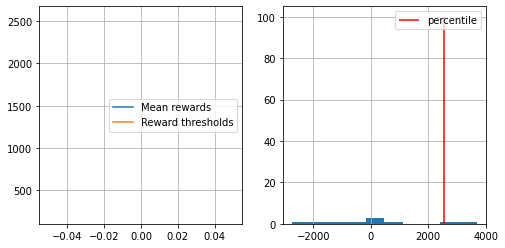

KeyboardInterrupt: 

In [48]:
%%time

#обучение
n_sessions = 10
percentile = 90
log = []

for i in range(10):
    # generate new sessions
    sessions = [generate_session(env, agent, t_max=99000) for i in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    #partial_fit agent to predict elite_actions(y) from elite_states(X)
    #обновляем сеть только при через элитные действия

    #agent.partial_fit(elite_states, elite_actions) #одна итерация по обучающим данным;
                                                    #если используем sklearn агента
    fit(elite_states, elite_actions, epochs)

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), 
                                                                np.max(rewards_batch)])

    if np.mean(rewards_batch) > 10000:
        print("You Win! The agent trades with some success. \
        You may stop training now via KeyboardInterrupt.")

In [351]:
#сохраняем агента - при необходимости
filename = 'agent.sav'
joblib.dump(agent, filename)

['agent.sav']

-- Проверочные примеры для собственной сети и ее обучения

In [150]:
#проверка работы сети
X = torch.rand(1, 200)
logits = model(X) 
pred_probab = nn.Softmax(dim=1)(logits)
pred_probab

tensor([[0.3284, 0.3117, 0.3599]], grad_fn=<SoftmaxBackward>)

In [137]:
#проверочное
y_test = torch.tensor([0, 1, 0, 2])
pred_test_dist = torch.tensor([[0.04, 0.15, 0.80], [0.10, 0.70, 0.20], 
                               [0.15, 0.25, 0.60], [0.8, 0.10, 0.10]])
pred_test = pred_test_dist.argmax(1)
(pred_test == y_test).type(torch.float).sum().item()

In [ ]:
#проверка
for batch, data in enumerate(train_dataloader):
    X = data['state']
    y = data['action']
    print((X, y))
    clear_output(True)

Проверка агента

In [24]:
#загружаем агента - если требуется
loaded_model = joblib.load('agent.sav')

In [49]:
%%time
#генерируем торговлю на одном проходе графика
review_states, review_actions, review_reward = generate_session(env, agent, t_max=99000)

CPU times: user 12.5 s, sys: 19.8 ms, total: 12.5 s
Wall time: 12.5 s


In [50]:
review_states, review_actions = elite_states, elite_actions

In [51]:
#служебная функция для преобразования
def start_end(positions, left_cut=0):
    '''Преобразовываем массив шагов с определенной позицией в непрерывные блоки 
    соответствующей позиции в формате [начало, конец]
    left_cut - задаем, если нужно, чтобы начинали набирать в массив не с начала
    (допустим, когда изображаем вначале графика state_size без какой-либо торговли
    для изначального контекста)'''
    positions_se = [] #positions start-end
    start = positions[0]
    end_check_index = 0
    for i in positions[:-1]:
        end_check_index += 1
        end_check = positions[end_check_index]
        if ((end_check - i) == 1) or (end_check < left_cut):
            continue
        else:
            end_index = end_check_index - 1
            end = positions[end_index]
            positions_se.append([start, end])
            new_start_index = end_check_index
            start = positions[new_start_index]
    positions_se.append([start, positions[-1]]) #дописываем последний блок, поскольку
                                                #процедура его никак иначе не найдет
    if left_cut > 0:
        positions_se = positions_se[1:]
        
    return positions_se

In [52]:
def calculate_trades(actions):
    ''' Расчет статистики частоты трейдов'''
    num_trades = 0
    num_ticks = len(actions)
    for i in range(num_ticks - 1):
        if (actions[i+1] - actions[i]) != 0:
            num_trades += 1
    return num_trades, num_ticks, num_trades/num_ticks

In [53]:
def display_evaluate_trading(track, positions, start, end, state_size=200):
    '''Функция, чтобы отрисовать и оценить торговлю в выборочном (любом) промежутке
    state_size - сколько нужно отобразить влево от стартовой точки
    По сути, старт графика будет на start-state_size
    Но старт отображения торговли будет не ранее start'''
    
    display_start = start - state_size #нужно только для первоначального среза
    track_to_display = track[display_start:end]
    positions_to_parse = np.array(positions[display_start:end])
    short_positions = start_end((positions_to_parse == 1).nonzero()[0], state_size)
    long_positions = start_end((positions_to_parse == 2).nonzero()[0], state_size)
    
    span = end - start
    states = []
    for i in range(span):
        rolling_end = i + state_size
        states.append(track_to_display[i:rolling_end])
    actions = positions[start:end]
    
    #изображаем
    clear_output(wait=True)
    plt.plot(track_to_display)

    for i in short_positions:
        x_1, x_2 = i[0], i[1]
        plt.axvspan(x_1, x_2, alpha=0.1, color='red')
    for i in long_positions:
        x_1, x_2 = i[0], i[1]
        plt.axvspan(x_1, x_2, alpha=0.1, color='green')

    plt.show(block=False);
    
    print('Статистика по частоте трейдов: ', *calculate_trades(actions))
    
    reward = int(input('Выберите вариант: ')) 
    
    return states, actions, reward   

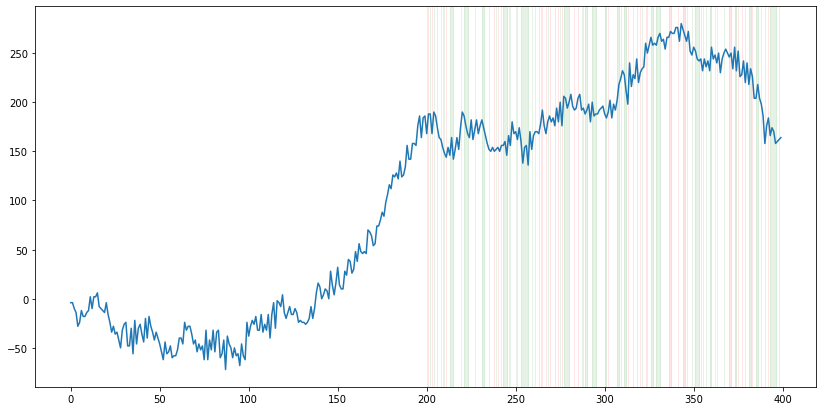

Статистика по частоте трейдов:  135 200 0.675


KeyboardInterrupt: Interrupted by user

In [54]:
output = display_evaluate_trading(loaded_track, elite_actions, 1000, 1200)